In [178]:
from gurobipy import *
from random import uniform
import itertools as it
import time
import cProfile as cP
import collections as coll
import math
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 5
def contig_name(contig):
    return contig[:contig.rfind('_')]
def get_contig_lengths(file):
    contig_len = {}
    for line in file:
        contig, length = line.split()
        length = int(length)
        if contig in contig_len:
            print("Error: double cont: " + contig + " | v1: " + str(contig_len[contig]) + " | v2: " + str(length))
        contig_len[contig] = length
    return contig_len

def read_file(file_name):
    """
    """
    data = []
    with open(file_name) as file:
        for line in file:
            a, b, dist = line.split()
            data.append([a, b, float(dist)])
    return data

def write_file(file_name, data):
    with open(file_name, 'w') as out:
        for a,b,dist in data:
            out.write(a +'\t'+ b +'\t'+str(dist) +'\n')
            
def write_sol(file_name, pos):
    pos = sorted(pos.items(), key = lambda x: x[1])
    with open(file_name, 'w') as out:
        for contig, position in pos:
            out.write(contig +'\t'+ str(position) + '\n')
            
def read_position(datei, ending = True):
    f = open(datei)
    
    position = {}
    contig_repeat = coll.defaultdict(list)
    
    for line in f:
        if ending:
            contig, pos = line.split()
            repeat = contig + '_' + str(len(contig_repeat[contig]))
        else:
            repeat, pos = line.split()
            contig = contig_name(repeat)
        
        position[repeat] = float(pos)
        contig_repeat[contig].append(repeat)
        
    return position, contig_repeat
            
def get_vars(data):
    contigs = set()
    for a, b, _ in data:
        contigs.add(a)
        contigs.add(b)
    return contigs

def find(x, i):
    
    l = [i]
    while i in x and i != x[i]:
        i = x[i]
        l += [i]
    
    for j in l:
        x[j] = i
        
    return i

def union(x,i,j):
    i = find(x,i)
    j = find(x,j)
    x[i] = j
        
def to_sets(struct):
    sets = coll.defaultdict(set)
    for element in struct:
        root = find(struct, element)
        sets[root].add(element)
    return sorted(sets.values(), key = lambda x: len(x), reverse = True)

def connected(data):
    struct = {}
    for a, b, _ in data:
        union(struct, a, b)
    sets = to_sets(struct)
    
    if len(sets) == 1:
        print('Die Daten sind zusammenhängend')
    else:
        print('Es gibt unzusammenhängende Regionen in den Daten')
        value = round(100 * len(sets[0]) / sum(len(x) for x in sets), 2)
        print(str(value) + '% der Contigs sind in der größten Komponente.')
       # print(sum(len(x) for x in sets[1:]))
       #print(sum(len(x) for x in sets[:]))
        
    return [constraint for constraint in data if constraint[0] in sets[0]]
#connected('my_apd200.lst')


def solve_LP(position, graph, folgende):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(folgende)
    
    contig.update(position)
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in graph.edges:
        eps = model.addVar()
       # faktor = (1000 + dist)/33942.74
        model.addConstr( contig[b] - contig[a] - dist <= eps ) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps ) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in folgende}

In [182]:
def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups


def gruppiert2(werte, min_abstand):
    sorted_werte = sorted(werte) 
    
    previous = sorted_werte[0]
    current_group = []
    max_len = 0
    for current in sorted_werte:
        if current - previous > min_abstand:
            
            this_len = len(current_group)
            if this_len > max_len:
                max_group = current_group[this_len//2]
                max_len = this_len
                
            current_group = []
            
        current_group.append(current)
        previous = current
        
    this_len = len(current_group)
    if this_len > max_len:
        max_group = current_group[this_len//2]
        max_len = this_len
        
    return max_group

data2 = read_file('my_apd199.lst')
data2 = connected(data2)
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    else:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}
#sorted([dist,a,b] for (a,b),(dist,gewicht) in Z.items())
print('len z[x] %6d'%sum(len(z[x]) for x in z))
print('len Z[x] %6d'%sum(len(Z[x]) for x in Z))
print('len C    %6d'%len(Z))
print('len Z-C  %6d'%(sum(len(Z[x]) for x in Z) - len(Z)))
print('len z-Z  %6d'%(sum(len(z[x]) for x in z) - sum(len(Z[x]) for x in Z)))


data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
len(data3)


Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
len z[x] 122219
len Z[x]  55642
len C     49415
len Z-C    6227
len z-Z   66577


55642

In [337]:
graph = nx.MultiDiGraph() 
for a, b, d in data2:
    if a != b:
        graph.add_edge(a,b,d)
        
aktuell = '2345APD_0'
position = {}
constr_pos = coll.defaultdict(list)
constr_pos[aktuell] = [0]
#besucht = []
def solve(graph, position, constr_pos):
    while constr_pos:
        pos, aktuell = min(
            (gruppiert2(constr_pos[contig], 500),contig) 
            for contig in constr_pos 
        )
        print(int(pos), aktuell)
        position[aktuell] = pos
        constr_pos.pop(aktuell)

        for contig in graph[aktuell]:
            for dist in graph[aktuell][contig]:
                constr_pos[contig].append(position[aktuell] + dist)
        graph.remove_node(aktuell)


        pre_position = {
            contig: gruppiert2(constr_pos[contig], 500)
            for contig in constr_pos 
        }
        
        subgraph = nx.DiGraph()
        for a,b,d in graph.subgraph(constr_pos).edges:
            if abs(pre_position[b] - pre_position[a] - d) < 5000:
                subgraph.add_edge(a,b)
                
        if not nx.is_weakly_connected(subgraph):
        #    print(i)
            komponenten = nx.weakly_connected_components(subgraph)
            
            graph_save = graph.copy()
            erg = (0,0)
            for k in komponenten:
                erg = max(erg, solve(graph.copy(),position.copy(),deepcopy(constr_pos.copy())))
                
            return erg
            
    l = len(position)
    print('erg',l)
    return l, position
solve(graph, position, constr_pos)

0 2345APD_0
6662 1483APD_0
6985 1395APD_0
9952 1596APD_0
14272 2235APD_0
14944 1534APD_0
16513 546APD_0
19016 577APD_0
32313 998APD_0
34132 209APD_0
43535 1635APD_0
45500 1911APD_0
45639 2109APD_0
47659 996APD_0
48897 1907APD_0
49148 1481APD_0
55769 2113APD_0
64348 1402APD_0
64492 1332APD_0
67989 1067APD_0
68360 225APD_0
77428 1894APD_0
80411 2448APD_0
80982 521APD_0
82899 2319APD_0
83282 1076APD_0
86439 301APD_0
88496 50APD_0
90523 2396APD_0
92157 1980APD_0
93237 958APD_0
95051 2050APD_0
99593 1113APD_0
101513 960APD_0
103144 831APD_0
106376 1877APD_0
107229 1337APD_0
109233 1630APD_0
114474 59APD_0
120932 542APD_0
124902 1631APD_0
126118 176APD_0
128321 567APD_0
130186 776APD_0
131473 86APD_0
137926 71APD_0
138150 1529APD_0
138835 1057APD_0
141008 1472APD_0
142758 1714APD_0
145446 1480APD_0
145967 1400APD_0
149564 2058APD_0
151223 943APD_0
151959 511APD_0
157350 1698APD_0
158547 1903APD_0
163517 1625APD_0
164035 2387APD_0
165636 1317APD_0
182587 212APD_0
182998 1857APD_0
185957 931AP

NetworkXPointlessConcept: Connectivity is undefined for the null graph.

In [325]:
a = coll.defaultdict(list)

defaultdict(list, {1: (3, 4)})

AttributeError: 'int' object has no attribute 'append'

In [324]:
graph = nx.MultiDiGraph() 
graph_save = graph
graph = graph_save.copy()
for a, b, d in data2:
    if a != b:
        graph.add_edge(a,b,d)
        
aktuell = '2345APD_0'
position = {aktuell: 0}
folgende = set()
constr_pos = coll.defaultdict(list)
besucht = []
for i in range(18004):
    folgende |= set(graph[aktuell])
    for c in graph[aktuell]:
        if c not in besucht:
            besucht.append(c)
    
    for contig in graph[aktuell]:
        for dist in graph[aktuell][contig]:
            constr_pos[contig].append(position[aktuell] + dist)
            
    
    pre_position = {
        contig: gruppiert2(constr_pos[contig], 500)
        for contig in constr_pos 
    }
    subgraph = nx.DiGraph()
    for a,b,d in graph.subgraph(folgende).edges:
        if abs(pre_position[b] - pre_position[a] - d) < 5000:
            subgraph.add_edge(a,b)
  #  subgraph = graph.subgraph(folgende)
    if not nx.is_weakly_connected(subgraph):
        print(i)
        komponenten = nx.weakly_connected_components(subgraph)
        for k in komponenten:
            
            preds = {
                for b in k
                for a in graph_save(b)    }
            if besucht[0] in k:
                komp = k
                break
        for c in folgende - komp:
            constr_pos.pop(c)
        folgende = komp
        
        """
        plot_graph = nx.DiGraph()
        for a,b,d in subgraph.edges:
            if d < 10000:
                plot_graph.add_edge(a,b)
        
        pydot = nx.nx_pydot.to_pydot(plot_graph)
        pydot.set_rankdir('LR')

        pydot.write_png('t.png')
      #  display(Image(filename='t.png'))
        1/0
        """
    graph.remove_node(aktuell)

    pos, aktuell = min(
        (gruppiert2(constr_pos[contig], 50000),contig) 
        for contig in constr_pos 
    )
    position[aktuell] = pos
    folgende.remove(aktuell)
    besucht.remove(aktuell)
    constr_pos.pop(aktuell)
    print(i,pos, aktuell)


0 6662.0 1483APD_0
1 6985.0 1395APD_0
2 9952.629129467889 1596APD_0
3 14272.0 2235APD_0
4 14944.0 1534APD_0
5 16513.62912946789 546APD_0
6 19016.62912946789 577APD_0
7 32313.62912946789 998APD_0
8 34132.62912946789 209APD_0
9 43535.62912946789 1635APD_0
10 45500.974360969696 1911APD_0
11 45639.62912946789 2109APD_0
12 47659.62912946789 996APD_0
13 48897.97919173 1907APD_0
14 49148.62912946789 1481APD_0
15 55769.62912946789 2113APD_0
16 64348.99773653042 1402APD_0
17 64490.76520070594 1332APD_0
18 67989.62912946788 1067APD_0
19 68358.62912946788 225APD_0
20 77421.62912946788 1894APD_0
21 80411.62912946788 2448APD_0
22 80975.62912946788 521APD_0
23 82892.62912946788 2319APD_0
24 83275.62912946788 1076APD_0
25 86432.62912946788 301APD_0
26 88489.62912946788 50APD_0
27 90516.56143478458 2396APD_0
28 92151.62912946788 1980APD_0
29 93230.56143478458 958APD_0
30 95045.56143478458 2050APD_0
31 99586.56143478458 1113APD_0
32 101506.56143478458 960APD_0
33 103137.56143478458 831APD_0
34 106369.5

263 613488.5614347846 2075APD_0
264 613657.5614347846 462APD_0
265
265 613866.9058127162 413APD_0
266 614428.5614347846 1500APD_0
267 615199.5614347846 1APD_0
268 623684.5614347846 1245APD_0
269 625011.5614347846 1423APD_0
270 632521.5614347846 2420APD_0
271 635665.5614347846 1439APD_0


NetworkXPointlessConcept: Connectivity is undefined for the null graph.

In [316]:
a = '2448APD_0'
b = '1076APD_0'
pp = {'521APD_0': 81144.0, '1586APD_0': 325305.7978785027, '277APD_0': 241746.7978785027, '832APD_0': 327764.7978785027, '885APD_0': 235271.7978785027, '480APD_0': 268802.7978785027, '2380APD_0': 297390.7978785027, '1635APD_0': 43667.78390277105, '1698APD_0': 157515.7978785027, '945APD_0': 214523.7978785027, '567APD_0': 128467.0, '2113APD_0': 55907.79787850269, '1631APD_0': 125067.7978785027, '2197APD_0': 251174.7978785027, '374APD_0': 244292.7978785027, '1494APD_0': 326793.7978785027, '1395APD_0': 6985.0, '2396APD_0': 90695.0, '1400APD_0': 146091.7978785027, '2122APD_0': 322251.7978785027, '1903APD_0': 158714.7978785027, '1390APD_0': 298817.7978785027, '1397APD_0': 233726.7978785027, '1596APD_0': 9929.0, '1980APD_0': 92334.0, '157APD_0': 314753.7978785027, '216APD_0': 302442.7978785027, '2387APD_0': 164183.7978785027, '59APD_0': 114620.7978785027, '943APD_0': 151385.7978785027, '1248APD_0': 330481.7978785027, '896APD_0': 195253.7978785027, '2322APD_0': 199741.7978785027, '1332APD_0': 64633.79787850269, '1017APD_0': 239729.7978785027, '2013APD_0': 196959.7978785027, '1543APD_0': 289522.7978785027, '1857APD_0': 183181.7978785027, '684APD_0': 309170.7978785027, '793APD_0': 227398.7978785027, '506APD_0': 264110.7978785027, '176APD_0': 126284.7978785027, '898APD_0': 312273.7978785027, '301APD_0': 86623.0, '776APD_0': 130345.0, '1877APD_0': 106537.0, '772APD_0': 194554.7978785027, '50APD_0': 88668.7978785027, '1529APD_0': 138307.7978785027, '156APD_0': 188013.7978785027, '1921APD_0': 222935.7978785027, '577APD_0': 19040.0, '1076APD_0': 83466.0, '996APD_0': 47786.78390277105, '1363APD_0': 219752.7978785027, '225APD_0': 68516.7978785027, '876APD_0': 226225.7978785027, '1113APD_0': 99751.7978785027, '1334APD_0': 272746.7978785027, '2235APD_0': 14289.77735087276, '1991APD_0': 229587.7978785027, '1701APD_0': 307670.8401888147, '209APD_0': 34260.78390277105, '1380APD_0': 220532.7978785027, '1942APD_0': 324633.7978785027, '466APD_0': 274632.7978785027, '1714APD_0': 142914.7978785027, '855APD_0': 279147.7978785027, '1151APD_0': 206054.10848268887, '1622APD_0': 331630.7978785027, '948APD_0': 203601.7978785027, '1481APD_0': 49275.79787850269, '2109APD_0': 45767.78390277105, '1246APD_0': 271773.7978785027, '1337APD_0': 107388.0, '638APD_0': 300870.7978785027, '546APD_0': 16529.0, '1779APD_0': 218580.7978785027, '831APD_0': 103302.7978785027, '960APD_0': 101673.7978785027, '2088APD_0': 252470.7978785027, '542APD_0': 121090.7978785027, '1472APD_0': 141162.7978785027, '764APD_0': 311475.7978785027, '1894APD_0': 77591.0, '2458APD_0': 267933.7978785027, '241APD_0': 332487.7978785027, '580APD_0': 254932.34992752428, '1955APD_0': 295639.7978785027, '86APD_0': 131631.7978785027, '958APD_0': 93409.0, '2085APD_0': 215176.7978785027, '1590APD_0': 329066.7978785027, '1057APD_0': 138989.7978785027, '318APD_0': 280452.7978785027, '1534APD_0': 14959.0, '998APD_0': 32438.78390277105, '2050APD_0': 95225.7978785027, '1904APD_0': 212478.7978785027, '88APD_0': 291884.7978785027, '1514APD_0': 247150.7978785027, '1483APD_0': 6658.0, '1317APD_0': 165803.7978785027, '19APD_0': 190714.7978785027, '2058APD_0': 149704.7978785027, '1465APD_0': 225025.7978785027, '931APD_0': 186152.7978785027, '1375APD_0': 186995.7978785027, '205APD_0': 236079.7978785027, '511APD_0': 152124.7978785027, '1252APD_0': 193799.7978785027}
cp = {'1017APD_0': [239759.0, 239743.0, 239788.62912946788, 239753.0, 239726.0, 239706.62912946788, 239617.62912946788, 239631.62912946788, 239611.62912946788], '1057APD_0': [139035.0, 139019.0, 139064.62912946788, 139029.0, 139002.0, 138982.62912946788, 138893.62912946788, 138907.62912946788, 138887.62912946788], '1076APD_0': [83482.0, 83466.0, 83511.62912946788, 83476.0, 83449.0, 83429.62912946788, 83340.62912946788, 83354.62912946788, 82970.62912946788, 83334.62912946788], '1113APD_0': [99789.0, 99773.0, 99818.62912946788, 99783.0, 99756.0, 99736.62912946788, 99647.62912946788, 99661.62912946788, 99641.62912946788], '1151APD_0': [206127.0, 206111.0, 206156.62912946788, 206121.0, 206094.0, 206074.62912946788, 205985.62912946788, 205999.62912946788, 205979.62912946788], '1246APD_0': [271927.0, 271911.0, 271956.6291294679, 271921.0, 271894.0, 271874.6291294679, 271785.6291294679, 271799.6291294679, 271779.6291294679], '1248APD_0': [330572.0, 330556.0, 330601.6291294679, 330566.0, 330539.0, 330519.6291294679, 330430.6291294679, 330444.6291294679, 330424.6291294679], '1252APD_0': [193845.0, 193829.0, 193874.62912946788, 193839.0, 193812.0, 193792.62912946788, 193703.62912946788, 193717.62912946788, 193697.62912946788], '1317APD_0': [165833.0, 165817.0, 165862.62912946788, 165827.0, 165800.0, 165780.62912946788, 165691.62912946788, 165705.62912946788, 165685.62912946788], '1332APD_0': [64645.0, 64629.0, 64674.62912946789, 64639.0, 64612.0, 64592.62912946789, 64503.62912946789, 64517.62912946789, 64334.62912946789, 64380.62912946789, 64497.62912946789], '1334APD_0': [272905.0, 272889.0, 272934.6291294679, 272899.0, 272872.0, 272852.6291294679, 272763.6291294679, 272777.6291294679, 272757.6291294679], '1337APD_0': [107434.0, 107418.0, 107463.62912946788, 107428.0, 107401.0, 107381.62912946788, 107292.62912946788, 107306.62912946788, 107286.62912946788], '1363APD_0': [219787.0, 219771.0, 219816.62912946788, 219781.0, 219754.0, 219734.62912946788, 219645.62912946788, 219659.62912946788, 219639.62912946788], '1375APD_0': [187010.0, 186994.0, 187039.62912946788, 187004.0, 186977.0, 186957.62912946788, 186868.62912946788, 186882.62912946788, 186862.62912946788], '1380APD_0': [220577.0, 220561.0, 220606.62912946788, 220571.0, 220544.0, 220524.62912946788, 220435.62912946788, 220449.62912946788, 220429.62912946788], '1390APD_0': [298783.0, 298767.0, 298812.6291294679, 298777.0, 298750.0, 298730.6291294679, 298641.6291294679, 298655.6291294679, 298635.6291294679], '1397APD_0': [233716.0, 233700.0, 233745.62912946788, 233710.0, 233683.0, 233663.62912946788, 233574.62912946788, 233588.62912946788, 233568.62912946788], '1400APD_0': [146170.0, 146154.0, 146199.62912946788, 146164.0, 146137.0, 146117.62912946788, 146028.62912946788, 146042.62912946788, 146022.62912946788], '1465APD_0': [225062.0, 225046.0, 225091.62912946788, 225056.0, 225029.0, 225009.62912946788, 224920.62912946788, 224934.62912946788, 224914.62912946788], '1472APD_0': [141205.0, 141189.0, 141234.62912946788, 141199.0, 141172.0, 141152.62912946788, 141063.62912946788, 141077.62912946788, 141057.62912946788], '1481APD_0': [49284.0, 49268.0, 49313.62912946789, 49278.0, 49251.0, 49231.62912946789, 49142.62912946789, 49156.62912946789, 49062.62912946789, 49074.62912946789, 49128.62912946789, 49129.62912946789, 49130.62912946789, 49134.62912946789, 49136.62912946789, 49398.62912946789], '1494APD_0': [326907.0, 326891.0, 326936.6291294679, 326901.0, 326874.0, 326854.6291294679, 326765.6291294679, 326779.6291294679, 326759.6291294679], '1514APD_0': [247195.0, 247179.0, 247224.62912946788, 247189.0, 247162.0, 247142.62912946788, 247053.62912946788, 247067.62912946788, 247047.62912946788], '1529APD_0': [138351.0, 138335.0, 138380.62912946788, 138345.0, 138318.0, 138298.62912946788, 138209.62912946788, 138223.62912946788, 138203.62912946788], '1543APD_0': [289505.0, 289489.0, 289534.6291294679, 289499.0, 289472.0, 289452.6291294679, 289363.6291294679, 289377.6291294679, 289357.6291294679], '156APD_0': [188032.0, 188016.0, 188061.62912946788, 188026.0, 187999.0, 187979.62912946788, 187890.62912946788, 187904.62912946788, 187884.62912946788], '157APD_0': [314812.0, 314796.0, 314841.6291294679, 314806.0, 314779.0, 314759.6291294679, 314670.6291294679, 314684.6291294679, 314664.6291294679], '1586APD_0': [325389.0, 325373.0, 325418.6291294679, 325383.0, 325356.0, 325336.6291294679, 325247.6291294679, 325261.6291294679, 325241.6291294679], '1590APD_0': [329181.0, 329165.0, 329210.6291294679, 329175.0, 329148.0, 329128.6291294679, 329039.6291294679, 329053.6291294679, 329033.6291294679], '1622APD_0': [331738.0, 331722.0, 331767.6291294679, 331732.0, 331705.0, 331685.6291294679, 331596.6291294679, 331610.6291294679, 331590.6291294679], '1631APD_0': [125077.0, 125061.0, 125106.62912946788, 125071.0, 125044.0, 125024.62912946788, 124935.62912946788, 124949.62912946788, 124929.62912946788], '1635APD_0': [43666.0, 43650.0, 43695.62912946789, 43660.0, 43633.0, 43613.62912946789, 43498.62912946789, 43511.62912946789, 43524.62912946789, 43502.62912946789, 43509.62912946789, 43538.62912946789, 43504.62912946789, 43518.62912946789, 43522.62912946789, 43527.62912946789, 43529.62912946789, 43531.62912946789, 43532.62912946789, 43535.62912946789, 43536.62912946789, 43537.30804590941, 43539.62912946789, 43549.62912946789], '1698APD_0': [157544.0, 157528.0, 157573.62912946788, 157538.0, 157511.0, 157491.62912946788, 157402.62912946788, 157416.62912946788, 157396.62912946788], '1701APD_0': [307721.0, 307705.0, 307750.6291294679, 307715.0, 307688.0, 307668.6291294679, 307579.6291294679, 307593.6291294679, 307573.6291294679], '1714APD_0': [142957.0, 142941.0, 142986.62912946788, 142951.0, 142924.0, 142904.62912946788, 142815.62912946788, 142829.62912946788, 142809.62912946788], '176APD_0': [126313.0, 126297.0, 126342.62912946788, 126307.0, 126280.0, 126260.62912946788, 126171.62912946788, 126185.62912946788, 126165.62912946788], '1779APD_0': [218619.0, 218603.0, 218648.62912946788, 218613.0, 218586.0, 218566.62912946788, 218477.62912946788, 218491.62912946788, 218471.62912946788], '1857APD_0': [183198.0, 183182.0, 183227.62912946788, 183192.0, 183165.0, 183145.62912946788, 183056.62912946788, 183070.62912946788, 183050.62912946788], '1877APD_0': [106580.0, 106564.0, 106609.62912946788, 106574.0, 106547.0, 106527.62912946788, 106438.62912946788, 106452.62912946788, 106432.62912946788], '1894APD_0': [77631.0, 77615.0, 77660.62912946788, 77625.0, 77598.0, 77578.62912946788, 77489.62912946788, 77503.62912946788, 77164.62912946788, 77483.62912946788], '1903APD_0': [158729.0, 158713.0, 158758.62912946788, 158723.0, 158696.0, 158676.62912946788, 158587.62912946788, 158601.62912946788, 158581.62912946788], '1904APD_0': [212508.0, 212492.0, 212537.62912946788, 212502.0, 212475.0, 212455.62912946788, 212366.62912946788, 212380.62912946788, 212360.62912946788], '1921APD_0': [222972.0, 222956.0, 223001.62912946788, 222966.0, 222939.0, 222919.62912946788, 222830.62912946788, 222844.62912946788, 222824.62912946788], '1942APD_0': [324702.0, 324686.0, 324731.6291294679, 324696.0, 324669.0, 324649.6291294679, 324560.6291294679, 324574.6291294679, 324554.6291294679], '1955APD_0': [295586.0, 295570.0, 295615.6291294679, 295580.0, 295553.0, 295533.6291294679, 295444.6291294679, 295458.6291294679, 295438.6291294679], '1980APD_0': [92364.0, 92348.0, 92393.62912946788, 92358.0, 92331.0, 92311.62912946788, 92222.62912946788, 92236.62912946788, 91774.62912946788, 92216.62912946788], '1991APD_0': [229643.0, 229627.0, 229672.62912946788, 229637.0, 229610.0, 229590.62912946788, 229501.62912946788, 229515.62912946788, 229495.62912946788], '19APD_0': [190758.0, 190742.0, 190787.62912946788, 190752.0, 190725.0, 190705.62912946788, 190616.62912946788, 190630.62912946788, 190610.62912946788], '2013APD_0': [197002.0, 196986.0, 197031.62912946788, 196996.0, 196969.0, 196949.62912946788, 196860.62912946788, 196874.62912946788, 196854.62912946788], '2050APD_0': [95261.0, 95245.0, 95290.62912946788, 95255.0, 95228.0, 95208.62912946788, 95119.62912946788, 95133.62912946788, 94663.62912946788, 95113.62912946788], '2058APD_0': [149758.0, 149742.0, 149787.62912946788, 149752.0, 149725.0, 149705.62912946788, 149616.62912946788, 149630.62912946788, 149610.62912946788], '205APD_0': [236107.0, 236091.0, 236136.62912946788, 236101.0, 236074.0, 236054.62912946788, 235965.62912946788, 235979.62912946788, 235959.62912946788], '2085APD_0': [215207.0, 215191.0, 215236.62912946788, 215201.0, 215174.0, 215154.62912946788, 215065.62912946788, 215079.62912946788, 215059.62912946788], '2088APD_0': [252564.0, 252548.0, 252593.62912946788, 252558.0, 252531.0, 252511.62912946788, 252422.62912946788, 252436.62912946788, 252416.62912946788], '2109APD_0': [45794.0, 45778.0, 45823.62912946789, 45788.0, 45761.0, 45741.62912946789, 45652.62912946789, 45586.62912946789, 45666.62912946789, 45608.62912946789, 45609.62912946789, 45618.62912946789, 45626.62912946789, 45628.62912946789, 45632.62912946789, 45633.62912946789, 45637.62912946789, 45639.62912946789, 45646.62912946789, 45730.62912946789], '2113APD_0': [55908.0, 55892.0, 55937.62912946789, 55902.0, 55875.0, 55855.62912946789, 55766.62912946789, 55780.62912946789, 55652.62912946789, 55663.62912946789, 55704.62912946789, 55714.62912946789, 55760.62912946789, 56438.62912946789], '2122APD_0': [322298.0, 322282.0, 322327.6291294679, 322292.0, 322265.0, 322245.6291294679, 322156.6291294679, 322170.6291294679, 322150.6291294679], '216APD_0': [302441.0, 302425.0, 302470.6291294679, 302435.0, 302408.0, 302388.6291294679, 302299.6291294679, 302313.6291294679, 302293.6291294679], '2197APD_0': [251249.0, 251233.0, 251278.62912946788, 251243.0, 251216.0, 251196.62912946788, 251107.62912946788, 251121.62912946788, 251101.62912946788], '225APD_0': [68531.0, 68515.0, 68560.62912946788, 68525.0, 68498.0, 68478.62912946788, 68389.62912946788, 68403.62912946788, 68212.62912946788, 68230.62912946788, 68383.62912946788], '2322APD_0': [199813.0, 199797.0, 199842.62912946788, 199807.0, 199780.0, 199760.62912946788, 199671.62912946788, 199685.62912946788, 199665.62912946788], '2380APD_0': [297339.0, 297323.0, 297368.6291294679, 297333.0, 297306.0, 297286.6291294679, 297197.6291294679, 297211.6291294679, 297191.6291294679], '2387APD_0': [164245.0, 164229.0, 164274.62912946788, 164239.0, 164212.0, 164192.62912946788, 164103.62912946788, 164117.62912946788, 164097.62912946788], '2396APD_0': [90744.0, 90728.0, 90773.62912946788, 90738.0, 90711.0, 90691.62912946788, 90602.62912946788, 90616.62912946788, 90152.62912946788, 90596.62912946788], '241APD_0': [332604.0, 332588.0, 332633.6291294679, 332598.0, 332571.0, 332551.6291294679, 332462.6291294679, 332476.6291294679, 332456.6291294679], '2458APD_0': [268033.0, 268017.0, 268062.6291294679, 268027.0, 268000.0, 267980.6291294679, 267891.6291294679, 267905.6291294679, 267885.6291294679], '277APD_0': [241799.0, 241783.0, 241828.62912946788, 241793.0, 241766.0, 241746.62912946788, 241657.62912946788, 241671.62912946788, 241651.62912946788], '301APD_0': [86672.0, 86656.0, 86701.62912946788, 86666.0, 86639.0, 86619.62912946788, 86530.62912946788, 86544.62912946788, 86089.62912946788, 86524.62912946788], '318APD_0': [280418.0, 280402.0, 280447.6291294679, 280412.0, 280385.0, 280365.6291294679, 280276.6291294679, 280290.6291294679, 280270.6291294679], '374APD_0': [244347.0, 244331.0, 244376.62912946788, 244341.0, 244314.0, 244294.62912946788, 244205.62912946788, 244219.62912946788, 244199.62912946788], '466APD_0': [274805.0, 274789.0, 274834.6291294679, 274799.0, 274772.0, 274752.6291294679, 274663.6291294679, 274677.6291294679, 274657.6291294679], '480APD_0': [268910.0, 268894.0, 268939.6291294679, 268904.0, 268877.0, 268857.6291294679, 268768.6291294679, 268782.6291294679, 268762.6291294679], '506APD_0': [264194.0, 264178.0, 264223.6291294679, 264188.0, 264161.0, 264141.6291294679, 264052.6291294679, 264066.6291294679, 264046.6291294679], '50APD_0': [88723.0, 88707.0, 88752.62912946788, 88717.0, 88690.0, 88670.62912946788, 88581.62912946788, 88595.62912946788, 88133.62912946788, 88575.62912946788], '511APD_0': [152143.0, 152127.0, 152172.62912946788, 152137.0, 152110.0, 152090.62912946788, 152001.62912946788, 152015.62912946788, 151995.62912946788], '521APD_0': [81172.0, 81156.0, 81201.62912946788, 81166.0, 81139.0, 81119.62912946788, 81030.62912946788, 81044.62912946788, 80700.62912946788, 81024.62912946788], '542APD_0': [121105.0, 121089.0, 121134.62912946788, 121099.0, 121072.0, 121052.62912946788, 120963.62912946788, 120977.62912946788, 120957.62912946788], '567APD_0': [128524.0, 128508.0, 128553.62912946788, 128518.0, 128491.0, 128471.62912946788, 128382.62912946788, 128396.62912946788, 128376.62912946788], '580APD_0': [255050.0, 255034.0, 255079.62912946788, 255044.0, 255017.0, 254997.62912946788, 254908.62912946788, 254922.62912946788, 254902.62912946788], '59APD_0': [114647.0, 114631.0, 114676.62912946788, 114641.0, 114614.0, 114594.62912946788, 114505.62912946788, 114519.62912946788, 114499.62912946788], '638APD_0': [300833.0, 300817.0, 300862.6291294679, 300827.0, 300800.0, 300780.6291294679, 300691.6291294679, 300705.6291294679, 300685.6291294679], '684APD_0': [309221.0, 309205.0, 309250.6291294679, 309215.0, 309188.0, 309168.6291294679, 309079.6291294679, 309093.6291294679, 309073.6291294679], '764APD_0': [311534.0, 311518.0, 311563.6291294679, 311528.0, 311501.0, 311481.6291294679, 311392.6291294679, 311406.6291294679, 311386.6291294679], '772APD_0': [194563.0, 194547.0, 194592.62912946788, 194557.0, 194530.0, 194510.62912946788, 194421.62912946788, 194435.62912946788, 194415.62912946788], '776APD_0': [130382.0, 130366.0, 130411.62912946788, 130376.0, 130349.0, 130329.62912946788, 130240.62912946788, 130254.62912946788, 130234.62912946788], '793APD_0': [227458.0, 227442.0, 227487.62912946788, 227452.0, 227425.0, 227405.62912946788, 227316.62912946788, 227330.62912946788, 227310.62912946788], '831APD_0': [103345.0, 103329.0, 103374.62912946788, 103339.0, 103312.0, 103292.62912946788, 103203.62912946788, 103217.62912946788, 103197.62912946788], '832APD_0': [327883.0, 327867.0, 327912.6291294679, 327877.0, 327850.0, 327830.6291294679, 327741.6291294679, 327755.6291294679, 327735.6291294679], '855APD_0': [279102.0, 279086.0, 279131.6291294679, 279096.0, 279069.0, 279049.6291294679, 278960.6291294679, 278974.6291294679, 278954.6291294679], '86APD_0': [131674.0, 131658.0, 131703.62912946788, 131668.0, 131641.0, 131621.62912946788, 131532.62912946788, 131546.62912946788, 131526.62912946788], '876APD_0': [226285.0, 226269.0, 226314.62912946788, 226279.0, 226252.0, 226232.62912946788, 226143.62912946788, 226157.62912946788, 226137.62912946788], '885APD_0': [235286.0, 235270.0, 235315.62912946788, 235280.0, 235253.0, 235233.62912946788, 235144.62912946788, 235158.62912946788, 235138.62912946788], '88APD_0': [291897.0, 291881.0, 291926.6291294679, 291891.0, 291864.0, 291844.6291294679, 291755.6291294679, 291769.6291294679, 291749.6291294679], '896APD_0': [195290.0, 195274.0, 195319.62912946788, 195284.0, 195257.0, 195237.62912946788, 195148.62912946788, 195162.62912946788, 195142.62912946788], '898APD_0': [312348.0, 312332.0, 312377.6291294679, 312342.0, 312315.0, 312295.6291294679, 312206.6291294679, 312220.6291294679, 312200.6291294679], '931APD_0': [186153.0, 186137.0, 186182.62912946788, 186147.0, 186120.0, 186100.62912946788, 186011.62912946788, 186025.62912946788, 186005.62912946788], '943APD_0': [151415.0, 151399.0, 151444.62912946788, 151409.0, 151382.0, 151362.62912946788, 151273.62912946788, 151287.62912946788, 151267.62912946788], '945APD_0': [214549.0, 214533.0, 214578.62912946788, 214543.0, 214516.0, 214496.62912946788, 214407.62912946788, 214421.62912946788, 214401.62912946788], '948APD_0': [203684.0, 203668.0, 203713.62912946788, 203678.0, 203651.0, 203631.62912946788, 203542.62912946788, 203556.62912946788, 203536.62912946788], '958APD_0': [93456.0, 93440.0, 93485.62912946788, 93450.0, 93423.0, 93403.62912946788, 93314.62912946788, 93328.62912946788, 92855.62912946788, 93308.62912946788], '960APD_0': [101712.0, 101696.0, 101741.62912946788, 101706.0, 101679.0, 101659.62912946788, 101570.62912946788, 101584.62912946788, 101564.62912946788], '996APD_0': [47830.0, 47814.0, 47859.62912946789, 47824.0, 47797.0, 47777.62912946789, 47688.62912946789, 47702.62912946789, 47581.62912946789, 47612.62912946789, 47631.62912946789, 47637.62912946789, 47640.62912946789, 47651.62912946789, 47682.62912946789, 47820.62912946789], '1067APD_0': [67873.62912946788, 67883.62912946788], '2448APD_0': [80305.62912946788]}
f = {'521APD_0', '2448APD_0', '1586APD_0', '277APD_0', '832APD_0', '885APD_0', '480APD_0', '2380APD_0', '1635APD_0', '1698APD_0', '945APD_0', '567APD_0', '2113APD_0', '1631APD_0', '2197APD_0', '374APD_0', '1494APD_0', '2396APD_0', '1400APD_0', '2122APD_0', '1903APD_0', '1390APD_0', '1397APD_0', '1980APD_0', '157APD_0', '216APD_0', '2387APD_0', '59APD_0', '943APD_0', '1248APD_0', '896APD_0', '2322APD_0', '1332APD_0', '1017APD_0', '2013APD_0', '1543APD_0', '1857APD_0', '684APD_0', '793APD_0', '506APD_0', '176APD_0', '898APD_0', '301APD_0', '776APD_0', '1877APD_0', '772APD_0', '50APD_0', '1529APD_0', '156APD_0', '1921APD_0', '1076APD_0', '996APD_0', '1363APD_0', '225APD_0', '876APD_0', '1113APD_0', '1334APD_0', '1991APD_0', '1701APD_0', '1380APD_0', '1942APD_0', '466APD_0', '1714APD_0', '855APD_0', '1151APD_0', '1622APD_0', '948APD_0', '1481APD_0', '2109APD_0', '1246APD_0', '1337APD_0', '638APD_0', '1779APD_0', '831APD_0', '960APD_0', '2088APD_0', '542APD_0', '1472APD_0', '764APD_0', '1894APD_0', '2458APD_0', '241APD_0', '580APD_0', '1955APD_0', '86APD_0', '958APD_0', '2085APD_0', '1590APD_0', '1057APD_0', '318APD_0', '2050APD_0', '1904APD_0', '88APD_0', '1514APD_0', '1317APD_0', '19APD_0', '2058APD_0', '1465APD_0', '931APD_0', '1375APD_0', '205APD_0', '511APD_0', '1067APD_0', '1252APD_0'}

In [307]:
pre_positionen = {
        contig: gruppiert2(constr_pos[contig], 500)
        for contig in constr_pos 
    }
a in pp

False

In [321]:
a in pre_position

False

In [303]:
cp[a],sorted(cp[b]),a in f, b in f, pp[b]

([80305.62912946788],
 [82970.62912946788,
  83334.62912946788,
  83340.62912946788,
  83354.62912946788,
  83429.62912946788,
  83449.0,
  83466.0,
  83476.0,
  83482.0,
  83511.62912946788],
 True,
 True,
 83466.0)

In [282]:
positions,constr_poss,besuchts,folgendes,graphs = deepcopy([position,constr_pos,besucht,folgende,graph])

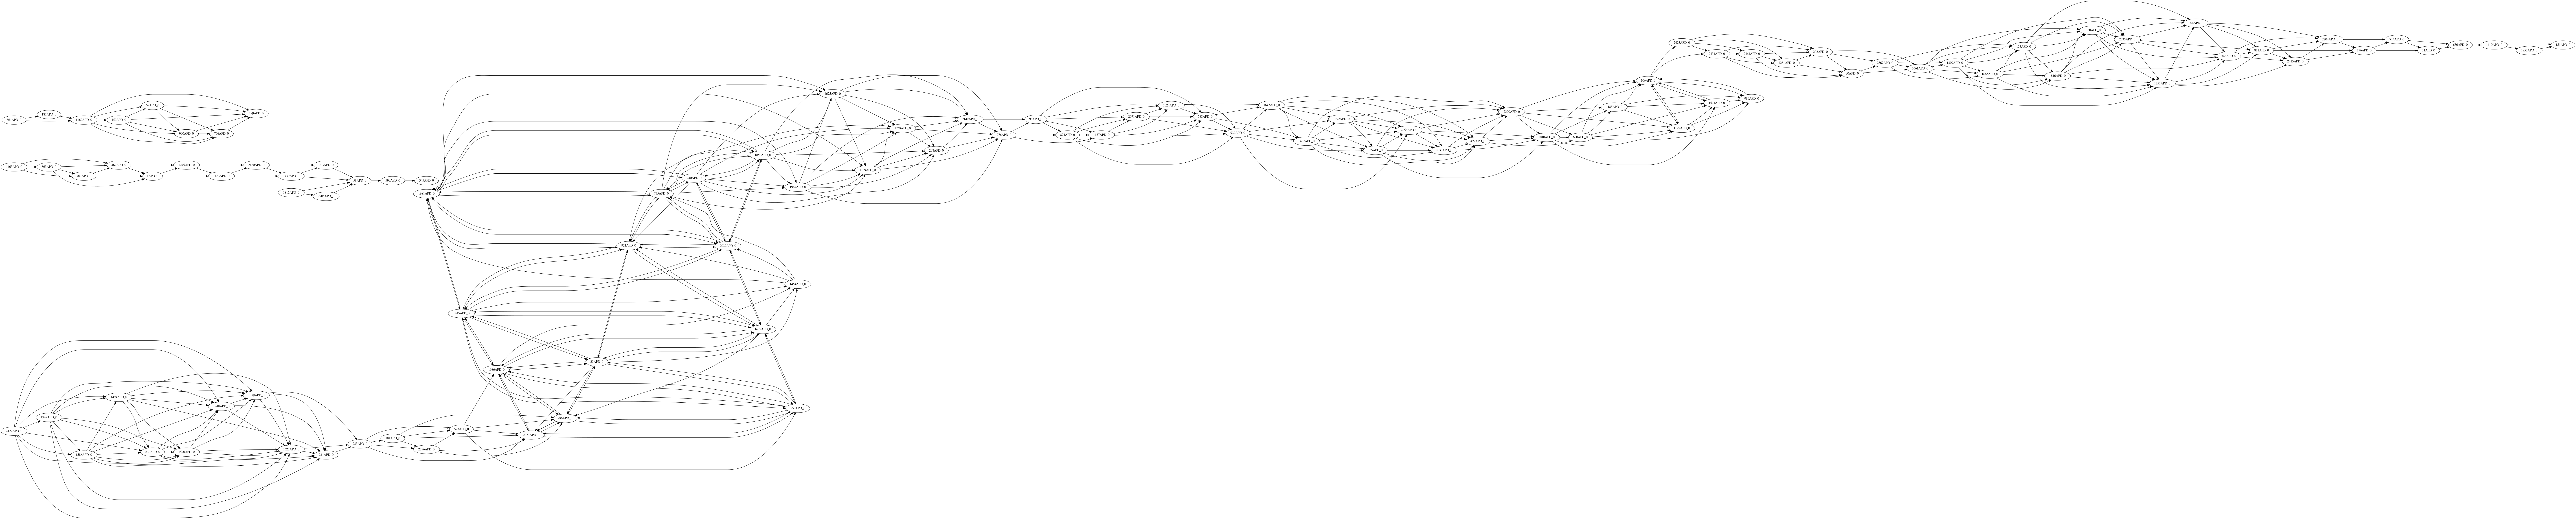

0 317899.56143478455 235APD_0


In [290]:
#position,constr_pos,besucht,folgende,graph = deepcopy([positions,constr_poss,besuchts,folgendes,graphs])

for i in range(1):
    folgende |= set(graph[aktuell])
    for c in graph[aktuell]:
        if c not in besucht:
            besucht.append(c)
    
    for contig in graph[aktuell]:
        for dist in graph[aktuell][contig]:
            constr_pos[contig].append(position[aktuell] + dist)
            
    subgraph = graph.subgraph(folgende)
    
    plot_graph = nx.DiGraph()
    for a,b,d in subgraph.edges:
        if d < 10000:
            plot_graph.add_edge(a,b)

    pydot = nx.nx_pydot.to_pydot(plot_graph)
    pydot.set_rankdir('LR')

    pydot.write_png('t.png')
    display(Image(filename='t.png'))
    
    if not nx.is_weakly_connected(subgraph):
        komponenten = nx.weakly_connected_components(subgraph)
        for k in komponenten:
            if besucht[0] in k:
                komp = k
                break
        for c in folgende - komp:
            constr_pos.pop(c)
        folgende = komp
        
    graph.remove_node(aktuell)

    pos, aktuell = min(
        (gruppiert2(constr_pos[contig], 50000),contig) 
        for contig in constr_pos 
    )
    position[aktuell] = pos
    folgende.remove(aktuell)
    besucht.remove(aktuell)
    constr_pos.pop(aktuell)
    print(i,pos, aktuell)

In [269]:
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName


def plot_graph(position, data, intName, X, repeat, von = 240, bis = 280, kantenanzahl = 3, fehler = 1000):

    s = coll.defaultdict(set)
    p = coll.defaultdict(set)

    graph = nx.DiGraph() 
    for c in X:
        if contig_name(c) == repeat:
            graph.add_node(intName[c],color = 'green')
        else:
            graph.add_node(intName[c],color = 'red')
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a].add(b)
            p[b].add(a)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    
    for el in pp:
        for pr in pp[el]:
            graph.add_edge(intName[pr],intName[el])
           # graph.add_edge(pr,el)
    for el in ss:
        for su in ss[el]:
          #  graph.add_edge(el,su)
            graph.add_edge(intName[el],intName[su])

    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
    display(Image(filename='t.png'))
    
def get_constr_pos(data, position):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        
        constr_pos[b].append((position[a] + dist, a, -dist, True))
        constr_pos[a].append((position[b] - dist, b, dist, False))
    return dict(constr_pos)

def plot_graph_rev(position, data, von = -1, bis = 3280, kantenanzahl = 2, fehler = 1000):
    
    intName = get_intName(position)
    
    s = coll.defaultdict(set)
    p = coll.defaultdict(set)

    graph = nx.DiGraph() 
    
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a].add(b)
            p[b].add(a)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    endpunkte = (set(pp) - set(ss)) | (set(ss) - set(pp))
    """
    
    for a, b, dist in data:
        if a in endpunkte or b in endpunkte:
            if position[a] > position[b]:
                a, b = b, a
            graph.add_edge(intName[a],intName[b],color = 'red')
    """
    constr_pos = get_constr_pos(data,position)
    for a in endpunkte:
        groups = gruppierung_Q(constr_pos[a], 1000)
        for group in groups:
            b = group.contig
            if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
                continue
            if position[a] > position[b]:
                color = 'red' if group.orientierung else 'green'
                graph.add_edge(intName[b],intName[a],color = color)
            else:
                color = 'blue' if group.orientierung else 'indigo'
                graph.add_edge(intName[a],intName[b],color = color)
            
    for el in pp:
        for pr in pp[el]:
            graph.add_edge(intName[pr],intName[el])
           # graph.add_edge(pr,el)
    for el in ss:
        for su in ss[el]:
          #  graph.add_edge(el,su)
            graph.add_edge(intName[el],intName[su])
    
  #  graph = pfadkontraktion2(graph)
    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
 #   display(Image(filename='t.png'))


def extrahiere_daten_Q(gruppe):
    gruppe, counter, dist_contig, orientierung  = gruppe
    
    if len(orientierung) != 1:
        return
    Repeat = coll.namedtuple('Repeat', ['contig', 'güte', 'orientierung'])

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values()) - 1) / (200+np.std(gruppe))
    
    if güte == 0:
        return
    
    dist_contig.sort()
    if {True} == orientierung:
        contig = dist_contig[-1][1]
    elif {False} == orientierung:
        contig = dist_contig[0][1]
    else:
        1/0
        
    return Repeat(
        contig = contig, 
        güte = güte,
        orientierung = list(orientierung)[0],
    )
   
def gruppierung_Q(positionen, min_abstand):
    
    sorted_pos = sorted(positionen) 
    
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),[],set()]
    groups = []
    
    for current, contig, dist, direction in sorted_pos:
        if current - previous > min_abstand:
            g = extrahiere_daten_Q(current_group)
            if g:
                groups.append(g)
            current_group = [[],coll.Counter(),[],set()]
            
        current_group[0].append(current)
        current_group[1][contig] += 1
        current_group[2].append((dist, contig))
        current_group[3].add(direction)
        
        previous = current
        
    g = extrahiere_daten_Q(current_group)
    if g:
        groups.append(g)
    
  #  groups = [g for g in groups if g.güte > 0]
    
    return groups


In [270]:
data3 = [[a,b,d] for a,b,d in data2 if a in position and b in position]

In [271]:
intName = get_intName(position)
plot_graph_rev(position,data3,-1,400)

In [181]:





pre_position = [
    (position[start] + dist, start, b, dist) 
    for b in graph.successors(start) 
    for dist in graph[start][b]
] 
nächster = min(pre_position)[2]

pre_position[0][2]


subgraph = nx.MultiDiGraph(subgraph) 
subgraph.add_edges_from( 
    (a, b, dist)
    for b in folgende 
    for a in graph.predecessors(b) if a in position
    for dist in graph[a][b]
)

#%timeit pre_position = solve_LP(position, subgraph, folgende)


3.33 s ± 59.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [152]:
subgraph = graph.subgraph(graph.successors(start))

In [177]:
3 * 2000 /60

100.0

In [165]:
for x,j in i:
    if j == 0:
        print(x)

1483APD_0


('1252APD_0', 84)

In [130]:
[x for x in graph.predecessors('1001APD_0')] == [x for x in graph.pred['1001APD_0']]

True

In [119]:
start = '2345APD_0'
position = {start: 0}

constr_pos = coll.defaultdict(list)
for contig in graph[start]:
    for dist in graph[start][contig]:
        constr_pos[contig].append(position[start] + dist)

folgende_contigs = sorted(
    (pos,contig,anz) 
    for contig in constr_pos 
    for pos, anz in gruppiert(constr_pos[contig], 500)
)

nächster = folgende_contigs[0]
nächster

(6662.0, '1483APD_0', 3)

In [51]:
for d, a, b, m in data3:
    graph.add_edge(a,b, key = d, anzahl = m)

In [53]:

print(min((dist,x) for x in graph[start] for dist in graph[start][x]))

(6662.0, '1483APD_0')


In [65]:
a = graph[start]['1596APD_0']
a = graph['1596APD_0']

In [48]:
[graph[start][x]for x in graph[start]]

[AtlasView({0: {'keye': 239759.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 139035.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 83482.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 99789.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 206127.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 271927.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 330572.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 193845.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 165833.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 64645.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 272905.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 107434.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 219787.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 187010.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 220577.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 298783.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 6982.0, 'anzahl': 11}}),
 AtlasView({0: {'keye': 233716.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 146170.0, 'anzahl': 1}}),
 AtlasView({0: {'keye': 225062.0, 'anzahl': 1}}),
 Atl

In [99]:
sub = graph.subgraph(graph[start])

In [107]:
for e in sub.edges:
    print(e)
    print(sub.edges[e])
    break

('521APD_0', '1017APD_0', 158582.0)
{}


In [108]:
model = Model()
model.addVars(sub)

Academic license - for non-commercial use only


{'521APD_0': <gurobi.Var C0>,
 '1586APD_0': <gurobi.Var C1>,
 '277APD_0': <gurobi.Var C2>,
 '832APD_0': <gurobi.Var C3>,
 '885APD_0': <gurobi.Var C4>,
 '480APD_0': <gurobi.Var C5>,
 '2380APD_0': <gurobi.Var C6>,
 '1635APD_0': <gurobi.Var C7>,
 '1698APD_0': <gurobi.Var C8>,
 '945APD_0': <gurobi.Var C9>,
 '567APD_0': <gurobi.Var C10>,
 '2113APD_0': <gurobi.Var C11>,
 '1631APD_0': <gurobi.Var C12>,
 '2197APD_0': <gurobi.Var C13>,
 '374APD_0': <gurobi.Var C14>,
 '1494APD_0': <gurobi.Var C15>,
 '1395APD_0': <gurobi.Var C16>,
 '2396APD_0': <gurobi.Var C17>,
 '1400APD_0': <gurobi.Var C18>,
 '2122APD_0': <gurobi.Var C19>,
 '1903APD_0': <gurobi.Var C20>,
 '1390APD_0': <gurobi.Var C21>,
 '1397APD_0': <gurobi.Var C22>,
 '1596APD_0': <gurobi.Var C23>,
 '1980APD_0': <gurobi.Var C24>,
 '157APD_0': <gurobi.Var C25>,
 '216APD_0': <gurobi.Var C26>,
 '2387APD_0': <gurobi.Var C27>,
 '59APD_0': <gurobi.Var C28>,
 '943APD_0': <gurobi.Var C29>,
 '1248APD_0': <gurobi.Var C30>,
 '896APD_0': <gurobi.Var C31>,


In [114]:
np.mean([d for _,_,d in data2])
    

32942.74107322483

In [116]:
x = [d for _,_,d in data2]
x.sort()

In [118]:
x[len(x)//2]

12534.0